# Pipeline Notebook 

## Imports

In [1]:
import keras
import tensorflow as tf
import handwriting.preprocess as preprocess
import cv2

## Bounding Box

### Bounding Box Modell

## Show Image Real Image

In [2]:
from bounding_box.model import load_weight_model,predict_image,get_image_as_array, show_image 
from bounding_box.config import NUM_CLASSES_ALL,BBOX_PATH,MAIN_BBOX_DETECTOR_MODEL,SUB_BBOX_DETECTOR_MODEL  
from bounding_box.model import load_weight_model, predict_image,plot_image, get_templated_data, edit_sub_boxes_cut_links, edit_sub_boxes_cut_top
from bounding_box.template import build_templating_data
from bounding_box.ressize import scale_up

bbox_model = load_weight_model(r"bounding_box\workspace\models\main_bbox_detector_model.h5",4)
image_path = "data_zettel/optimal_page/nathan_optimal.jpg"
original_image = cv2.imread(image_path)

Using TensorFlow backend


c:\Users\hadie\anaconda3\envs\py10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Prediction

1/1 [==============================] - 16s 16s/step
(3.2291666666666665, 2.283203125)


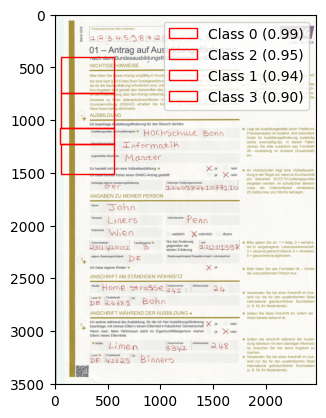

In [3]:
main_boxes, confidence, classes, ratios = predict_image(image_path, bbox_model)
print(ratios)
show_image(image_path, main_boxes, confidence, classes)  

### Templating

In [4]:
org_ms_boxes_person, org_ms_boxes_wohnsitz, org_ms_boxes_ausbildung, org_ms_boxes_wwa, person_class_ids, ausbildung_class_ids, wohnsitz_class_ids, wwa_class_ids, widthOrgImag, heightOrgImag = build_templating_data()

ausbildung, person, wohnsitz, wwa, best_predicted = get_templated_data(main_boxes, confidence, classes, org_ms_boxes_person,
                                                                       org_ms_boxes_wohnsitz, org_ms_boxes_ausbildung,
                                                                       org_ms_boxes_wwa, person_class_ids,
                                                                       ausbildung_class_ids, wohnsitz_class_ids,
                                                                       wwa_class_ids)
top_cut = False
if top_cut:
    ausbildung_cut, person_cut, wohnsitz_cut, wwa_cut = edit_sub_boxes_cut_top(ausbildung, person, wohnsitz, wwa)
else:
    ausbildung_cut, person_cut, wohnsitz_cut, wwa_cut = edit_sub_boxes_cut_links(ausbildung, person, wohnsitz, wwa)


100%|██████████| 1/1 [00:00<?, ?it/s]


### Scale Templating up

In [5]:
ausbildung_cut_scaled, person_cut_scaled, wohnsitz_cut_scaled, wwa_cut_scaled = scale_up( ausbildung_cut, person_cut, wohnsitz_cut, wwa_cut, ratios)

In [6]:
sub_boxes = ausbildung_cut_scaled[0] + person_cut_scaled[0] +  wohnsitz_cut_scaled[0] +  wwa_cut_scaled[0] 
sub_classes = ausbildung_cut_scaled[1] + person_cut_scaled[1] + wohnsitz_cut_scaled[1] +  wwa_cut_scaled[1]

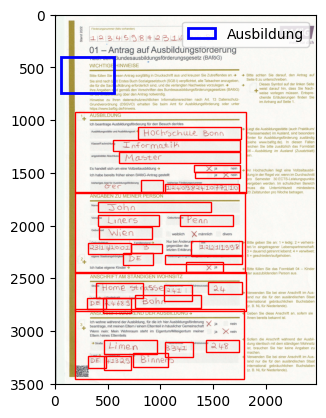

In [7]:
plot_image(image_path, ausbildung_cut_scaled, person_cut_scaled, wohnsitz_cut_scaled, wwa_cut_scaled, best_predicted)

### ROI Crop

In [8]:
from collections import namedtuple
ImageInfo = namedtuple('ImageInfo', ['image', 'sub_class','value'])

# Crop ROI
import cv2
from bounding_box.ressize import resize_imaged_without_expand_dim
from bounding_box.config import YOLO_WIDTH, YOLO_HEIGHT
def crop(xmin, ymin, xmax, ymax, image_path):
    image = cv2.imread(image_path)
    #image = resize_imaged_without_expand_dim(image, YOLO_WIDTH, YOLO_HEIGHT)
    xmin = int(round(xmin))
    ymin = int(round(ymin))
    xmax = int(round(xmax))
    ymax = int(round(ymax))
    # width = int(round(width))
    # height = int(round(height))
    # rowBeg = y
    # rowEnd = y + height
    # columnBeg = x
    # columnEnd = x + width
    imgCropped = image[ymin:ymax, xmin:xmax]
    print(imgCropped.shape)
    return imgCropped

import matplotlib.pyplot as plt
images_info_cropped = []
for i,box in enumerate(sub_boxes):
    xmin, ymin, xmax, ymax = box
    imgCropped = crop(xmin, ymin, xmax, ymax, image_path)
    image_info = ImageInfo(image=imgCropped,sub_class=sub_classes[i],value="")
    images_info_cropped.append(image_info)
    PLOT = False
    if PLOT:
        plt.axis("off")
        plt.imshow(imgCropped)
        plt.show()


(61, 432, 3)
(69, 429, 3)
(107, 1145, 3)
(77, 705, 3)
(104, 1204, 3)
(116, 981, 3)
(112, 212, 3)
(771, 1620, 3)
(88, 287, 3)
(95, 344, 3)
(88, 730, 3)
(114, 287, 3)
(134, 486, 3)
(101, 408, 3)
(112, 498, 3)
(105, 504, 3)
(104, 573, 3)
(95, 1075, 3)
(767, 1613, 3)
(119, 326, 3)
(106, 176, 3)
(128, 620, 3)
(147, 272, 3)
(147, 264, 3)
(142, 453, 3)
(368, 1623, 3)
(113, 314, 3)
(115, 172, 3)
(133, 331, 3)
(132, 255, 3)
(135, 260, 3)
(134, 508, 3)
(660, 1608, 3)


## Handwriting Recognition

### Preprocess Image

In [9]:
import numpy as np
import utils.configs as cfg
config_path = "utils/configs.json"
config = cfg.Config(config_path)
IMAGE_WIDTH = config.get_model_parameter()["width"] # default: 1024
IMAGE_HEIGHT = config.get_model_parameter()["height"] # default: 128

img_size=(IMAGE_WIDTH, IMAGE_HEIGHT)
preprocessed_image_infos = []
for image_info in images_info_cropped:
    image = image_info.image 
    image = np.mean(image, axis=2, keepdims=True)
    image = preprocess.distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    
    temp_sub_class = image_info.sub_class
    temp_image_info = ImageInfo(image=image,sub_class=temp_sub_class,value="")
    preprocessed_image_infos.append(temp_image_info)

### Plot Images

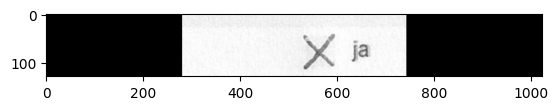

In [10]:
plot_image = preprocessed_image_infos[9].image
plot_image = np.transpose(plot_image, (1, 0, 2))
plot_image = np.flipud(plot_image)
plt.imshow(plot_image[:, :, 0],cmap='gray')

# Show the plot
plt.show()

### Handwriting Recognition Neural Network

In [11]:
from keras.models import load_model
import os
""" import handwriting.tokenizer as tokenizer """
import pickle
# Load from pickle file
IAM = False
if IAM:
    with open('iam_handwriting_model_characters.pkl', 'rb') as file:
        loaded_max_len, loaded_characters = pickle.load(file)
else:
    with open('bafog_handwriting_model_characters.pkl', 'rb') as file:
        loaded_max_len, loaded_characters = pickle.load(file)
    
with open('number_saved_max_len_char.pkl', 'rb') as file:
     max_len_num, character_num = pickle.load(file)
# Print loaded data
print("Loaded max_len:", loaded_max_len)
print("Loaded characters:", loaded_characters)

print("Loaded number max_len:", max_len_num)
print("Loaded number characters:", character_num)

Loaded max_len: 65
Loaded characters: ['[UNK]', '-', '.', '0', '1', '2', '4', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', 'ß', 'ä', 'ö', 'ü']
Loaded number max_len: 15
Loaded number characters: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [12]:
from keras.layers import StringLookup
char_to_num = StringLookup(vocabulary=list(loaded_characters), mask_token=None)
num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

number_char_to_num = StringLookup(vocabulary=list(character_num), mask_token=None)
number_num_to_char = StringLookup(vocabulary=number_char_to_num.get_vocabulary(), mask_token=None, invert=True)

def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :loaded_max_len]
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

def decode_number_pred(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :max_len_num]
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(number_num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

def load_model_numbers():
    model_weight_path = "models/only_numbers/transferlearningTestingModel_weights.keras"
    model_path = "models/only_numbers/"
    print(model_path)
    if os.path.exists(model_path):
        print("Loading pre-trained model and weights...")
        model = load_model(model_path)
        model.load_weights(model_weight_path)
        print("Model and weights loaded successfully.")

        return model
    else:
        print("No pre-trained model or weights found.")
        return None
def load_model_and_weights():
    if IAM:
        model_weight_path = "models/model9v3_xl/model9v3_xl_weights.keras"
        model_path = "models/model9v3_xl/"
    else:
        model_weight_path = "models/dense_and_full/transferlearningTestingModel_weights.keras"
        model_path = 'models/dense_and_full/'
        # model_weight_path = "models/denselayer1/transferlearningTestingModel_weights.keras"
        # model_path = 'models/denselayer1/'
    print(model_path)
    if os.path.exists(model_path):
        print("Loading pre-trained model and weights...")
        model = load_model(model_path)
        model.load_weights(model_weight_path)
        print("Model and weights loaded successfully.")

        return model
    else:
        print("No pre-trained model or weights found.")
        return None

In [13]:
# Neural Network Handwriting
handwriting_model = load_model_and_weights()
prediction_model = keras.models.Model(handwriting_model.get_layer(name="image").input, handwriting_model.get_layer(name="dense2").output)

number_model = load_model_numbers()
number_pred_model = keras.models.Model(number_model.get_layer(name="image").input, number_model.get_layer(name="dense2").output)

models/dense_and_full/
Loading pre-trained model and weights...


Model and weights loaded successfully.
models/only_numbers/
Loading pre-trained model and weights...
Model and weights loaded successfully.


### Spell Checker

In [14]:
def spell_checker(text):
    from spellchecker import SpellChecker
    spell = SpellChecker(language='de')
    words = [word for word in text.split(" ") if word != '']
    #Spellchecker
    corrected_text = ' '.join([spell.correction(word) if spell.correction(word) is not None else word for word in text.split()])
    return corrected_text
    

### Map Sub_Classes to String

In [15]:
import bounding_box.config as bounding_box_config
class_ids = bounding_box_config.class_ids

def map_sub_class_to_string_and_sort(class_number):
    temp_class_string = class_ids[class_number]
    
    not_class_list = ["Ausbildung_Klasse","Ausbildung","Person","Wohnsitz","Wohnsitz_waehrend_Ausbildung"]
    if temp_class_string not in not_class_list:
        return temp_class_string
    return -1
        

### Prediction

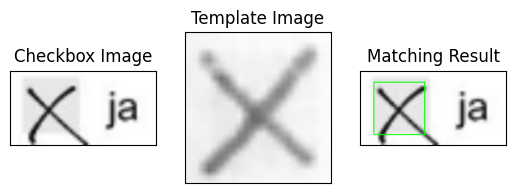

The checkbox is: True


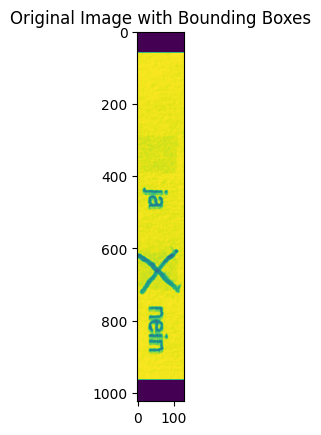

Ja X Count: 50193 Nein X Count: 54045


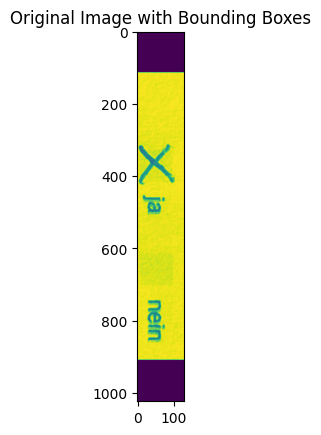

Ja X Count: 43284 Nein X Count: 49046
1/1 [==============================] - 0s 438ms/step


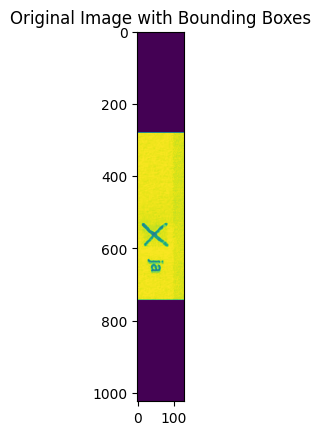

Ja X Count: 27203 Nein X Count: 28873
1/1 [==============================] - 0s 418ms/step


In [16]:
images_with_value = []
# Prediction
for i, preprocess_image in enumerate(preprocessed_image_infos):
    temp_sub_class = preprocess_image.sub_class
    temp_sub_class_string = map_sub_class_to_string_and_sort(temp_sub_class)
    number_sub_classes = ['Wohnsitz_waehrend_Ausbildung_Hausnummer','Wohnsitz_waehrend_Ausbildung_Postleitzahl','Wohnsitz_Hausnummer',
                          'Wohnsitz_Postleitzahl','Person_Geburtsdatum','Person_Familienstand_seit','Ausbildung_Foerderungsnummer']
    check_boxes_sub_classes =['Ausbildung_Antrag_gestellt_ja','Ausbildung_Vollzeit','Person_Kinder'] # hier fehlen noch welche sind aber noch nicht im templating
    
    if temp_sub_class_string != -1:
        if temp_sub_class_string in number_sub_classes:
            preds = number_pred_model.predict(tf.expand_dims(preprocess_image.image, axis=0))
            pred_texts = decode_number_pred(preds)
            number_prediction = pred_texts[0]
            temp_image_info = ImageInfo(image=preprocess_image.image,sub_class=temp_sub_class_string,value=number_prediction)
            images_with_value.append(temp_image_info)
        elif temp_sub_class_string in check_boxes_sub_classes:
            import contrast_true_or_false.contrast_tof as check_box_checker
            from PIL import Image
            numpy_array = preprocess_image.image.numpy()
            numpy_array = numpy_array.squeeze()
            numpy_array = np.clip(numpy_array, 0.0, 1.0)
            image_array_uint8 = (numpy_array * 255).astype(np.uint8)
            pil_image = Image.fromarray(image_array_uint8)
            result = check_box_checker.is_checkbox_checked(pil_image)
            
            
            temp_image_info = ImageInfo(image=preprocess_image.image,sub_class=temp_sub_class_string,value=result)
            images_with_value.append(temp_image_info)
        else:
            preds = prediction_model.predict(tf.expand_dims(preprocess_image.image, axis=0))
            pred_texts = decode_batch_predictions(preds)
            selected_pred_text = pred_texts[0]
            selected_pred_text = selected_pred_text.replace("|"," ")
            prediction_text = spell_checker(selected_pred_text)
            temp_image_info = ImageInfo(image=preprocess_image.image,sub_class=temp_sub_class_string,value=prediction_text)
            images_with_value.append(temp_image_info)
        

# Plot Predicted Text and Image

In [17]:
def plot_evaluation(images, rows=5, cols=None):
    num_images = len(images)
    if cols is None:
        cols = -(-num_images // rows)  # Ceiling division to calculate the number of columns

    fig, axes = plt.subplots(rows, cols, figsize=(25, 5))  # Adjust the figsize as needed

    for i, image in enumerate(images):
        pred_texts = image.value
        title = f"{image.sub_class}: {pred_texts}"
        plot_image = image.image
        
        plot_image = np.transpose(plot_image, (1, 0, 2))
        plot_image = np.flipud(plot_image)

        # Calculate the position of the subplot in the grid
        row_pos, col_pos = divmod(i, cols)

        # Use the appropriate axis for each subplot
        ax = axes[row_pos, col_pos] if num_images > 1 else axes

        ax.set_title(title)
        ax.imshow(plot_image[:, :, 0], cmap='gray')
        ax.axis('off')

    plt.tight_layout()  # Adjust subplot parameters for better layout
    plt.show()
    

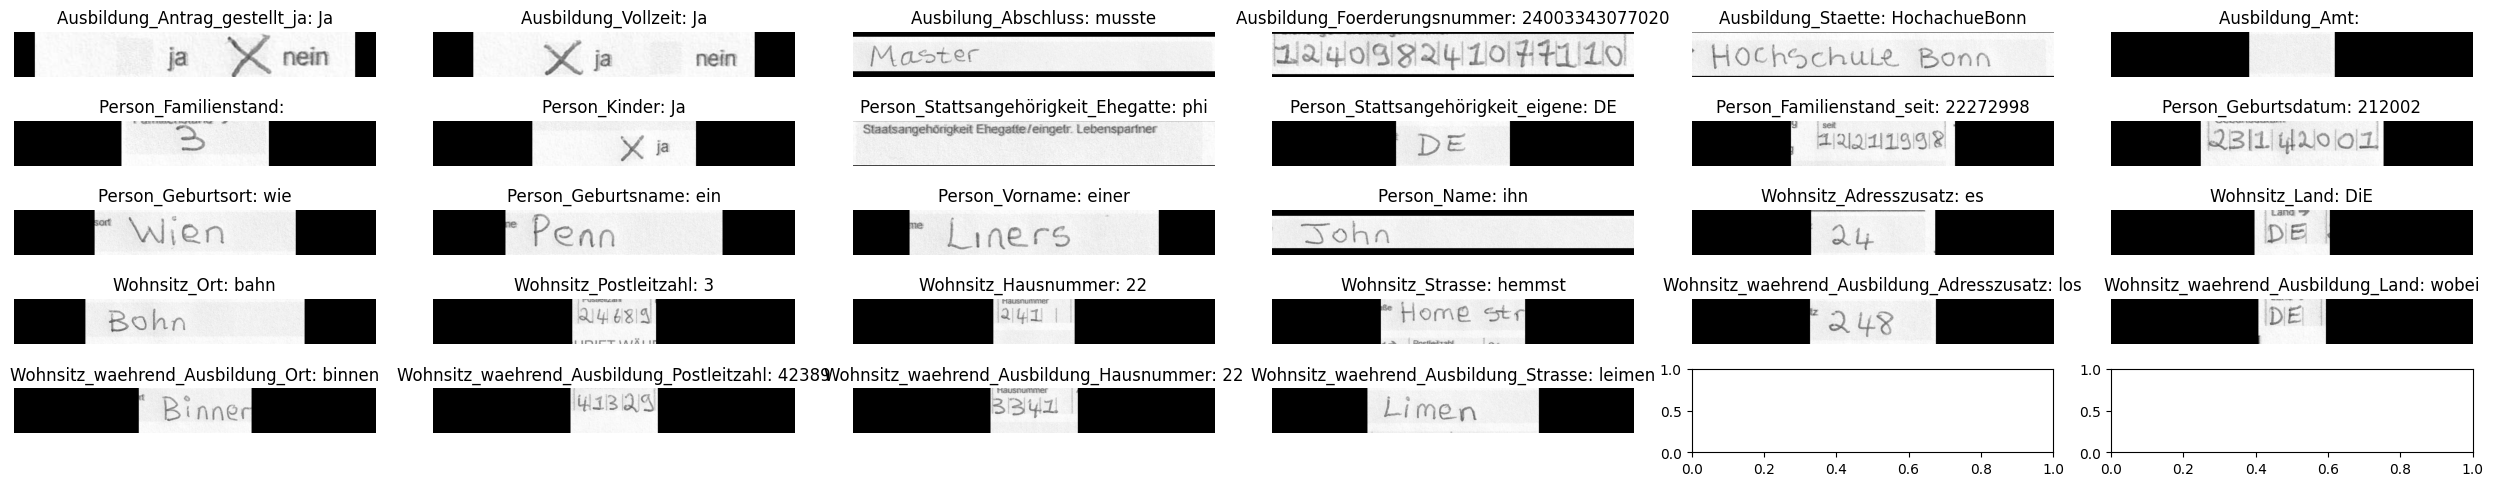

In [18]:
plot_evaluation(images_with_value)